<a href="https://colab.research.google.com/github/Marco-barthem/email-spam-classification/blob/main/spam_email_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando Dataset

In [ ]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Marco-barthem/email-spam-classification/refs/heads/main/Spam%20Email%20raw%20text%20for%20NLP.csv')
df

,CATEGORY,MESSAGE,FILE_NAME
0,1,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",00249.5f45607c1bffe89f60ba1ec9f878039a
1,1,ATTENTION: This is a MUST for ALL Computer Use...,00373.ebe8670ac56b04125c25100a36ab0510
2,1,This is a multi-part message in MIME format.\n...,00214.1367039e50dc6b7adb0f2aa8aba83216
3,1,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,00210.050ffd105bd4e006771ee63cabc59978
4,1,This is the bottom line. If you can GIVE AWAY...,00033.9babb58d9298daa2963d4f514193d7d6
...,...,...,...
5791,0,"I'm one of the 30,000 but it's not working ver...",00609.dd49926ce94a1ea328cce9b62825bc97
5792,0,Damien Morton quoted:\n\n>W3C approves HTML 4 ...,00957.e0b56b117f3ec5f85e432a9d2a47801f
5793,0,"On Mon, 2002-07-22 at 06:50, che wrote:\n\n\n\...",01127.841233b48eceb74a825417d8d918abf8
5794,0,"Once upon a time, Manfred wrote :\n\n\n\n> I w...",01178.5c977dff972cd6eef64d4173b90307f0


In [ ]:
df['CATEGORY'].value_counts()

,count
CATEGORY,
0,3900
1,1896


## Importando bibliotecas para NLP

In [ ]:
import nltk #Natural Language Tool Kit
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer

#tokenizer = ToktokTokenizer()
tokenizer =nltk.tokenize.RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english')

## Pre processamento

In [ ]:
def message_to_token_list(s): #Tokeniza as palavras da base
    tokens = tokenizer.tokenize(s)
    lower_case = [t.lower() for t in tokens]  # filtra símbolos e acentos
    lemmatizer_words = [lemmatizer.lemmatize(i) for i in lower_case]
    useful_tokens = [u for u in lemmatizer_words if u not in stopwords]
    return useful_tokens

In [ ]:
df = df.sample(frac=1,random_state=1) #Separndo a base de treino e de teste
df=df.reset_index(drop=True)

split_index = int(len(df)*0.8)
train_df,test_df = df[:split_index],df[split_index:]

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df,test_df

(      CATEGORY                                            MESSAGE  \
 0            1  \n\n<HTML><FONT  BACK="#ffffff" style="BACKGRO...   
 1            1  <html><body bgColor="#CCCCCC" topmargin=1 onMo...   
 2            0  Quoting Paul Linehan (plinehan@yahoo.com):\n\n...   
 3            0  <a href=http://www.aaronsw.com/weblog/>\n\nAar...   
 4            0  Oh yeah, the link for more info:\n\n\n\nhttp:/...   
 ...        ...                                                ...   
 4631         0  Gregory Alan Bolcer:\n\n>I'm not sure since I ...   
 4632         1  New Account For: zzzz@spamassassin.taint.org\n...   
 4633         0  >>>>> "O" == Owen Byrne <owen@permafrost.net> ...   
 4634         0  This is an automated response to a message you...   
 4635         0  http://www.ouchytheclown.com/welcome.html\n\n\...   
 
                                    FILE_NAME  
 0     00118.141d803810acd9d4fc23db103dddfcd9  
 1     00463.0bc4e08af0529dd773d9f10f922547db  
 2     00358.8

In [ ]:
token_counter = {}

for message in train_df['MESSAGE']:
  message_as_tkn_lst = message_to_token_list(message)
  for t in message_as_tkn_lst:
    if t not in token_counter:
      token_counter[t] = 1
    else:
      token_counter[t] += 1

len(token_counter)

86439

In [16]:
def keep_token(token,treshold): #Função que conseguimos o limar das palavras (Filtramos apenas as palavras com o maior limiar)
  if token not in token_counter:
    return False
  else:
    return token_counter[token] >= treshold

## Criando Bag of words

In [18]:
features=set()

for i in token_counter:
  if keep_token(i,10000):
    features.add(i)

features =list(features)
features #bag of words

['3d', 'td', 'size', 'tr', 'b', 'com', 'http', 'p', 'font', 'br']

In [34]:
token_to_index_mapping = {t:i for t,i in zip(features,range(len(features)))} #dicionário que mapeia cada token  para um índice numérico.
token_to_index_mapping


{'3d': 0,
 'td': 1,
 'size': 2,
 'tr': 3,
 'b': 4,
 'com': 5,
 'http': 6,
 'p': 7,
 'font': 8,
 'br': 9}

In [36]:
import numpy as np
def message_to_count_vector(message):
  count_vector = np.zeros(len(features))

  processed_token_list = message_to_token_list(message)

  for token in processed_token_list:
    if token not in features:
      continue
    index = token_to_index_mapping[token]
    count_vector[index] += 1
  return count_vector



In [37]:
message_to_count_vector(train_df['MESSAGE'].iloc[1])

array([ 0.,  4.,  7.,  1., 12.,  2.,  2., 10., 14., 22.])

In [28]:
train_df['MESSAGE'].iloc[1]

'<html><body bgColor="#CCCCCC" topmargin=1 onMouseOver="window.status=\'\'; return true" oncontextmenu="return false" ondragstart="return false" onselectstart="return false">\n\n<div align="center">Hello, jlnax@yahoo.com<BR><BR>\n\n</div><div align="center"></div><p align="center"><b><font face="Arial" size="4">Hum<!--jlnax-->an \n\nGro<!--jlnax-->wth \n\nHor<!--jlnax-->mone \n\nTher<!--jlnax-->apy</font>\n\n</b></p>\n\n<p align="center"><b><font face="Arial" size="4">Lo<!--jlnax-->se \n\nwei<!--jlnax-->ght while \n\nbuil<!--jlnax-->ding \n\nle<!--jlnax-->an \n\nmus<!--jlnax-->cle \n\nmass<br>and \n\nrever<!--jlnax-->sing the \n\nravag<!--jlnax-->es of \n\nag<!--jlnax-->ing all at once.</font><font face="Arial" size="3"><br>\n\n</font></b><font face="Arial" size="3"> <br>Remar<!--jlnax-->kable \n\ndiscov<!--jlnax-->eries about \n\nHum<!--jlnax-->an \n\nGro<!--jlnax-->wth \n\nHormo<!--jlnax-->nes \n\n(<b>HG<!--jlnax-->H</b>) \n\n<br>are changing the way we think about ag<!--jlnax-->ing 

In [29]:
train_df.iloc[1]

,1
CATEGORY,1
MESSAGE,"<html><body bgColor=""#CCCCCC"" topmargin=1 onMo..."
FILE_NAME,00463.0bc4e08af0529dd773d9f10f922547db


## Treinamento e resultados do Modelo

In [47]:
def df_to_x_y(df):
  y = df['CATEGORY'].to_numpy().astype(int)

  message_columns = df['MESSAGE']

  count_vectors = []

  for message in message_columns:
    count_vector = message_to_count_vector(message)
    count_vectors.append(count_vector)

  X = np.array(count_vectors).astype(int)

  return X, y

In [49]:
X_train,y_train = df_to_x_y(train_df)

X_test,y_test = df_to_x_y(test_df)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4636, 10), (4636,), (1160, 10), (1160,))

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

              precision    recall  f1-score   support

           0       0.76      1.00      0.86       788
           1       0.99      0.32      0.48       372

    accuracy                           0.78      1160
   macro avg       0.87      0.66      0.67      1160
weighted avg       0.83      0.78      0.74      1160



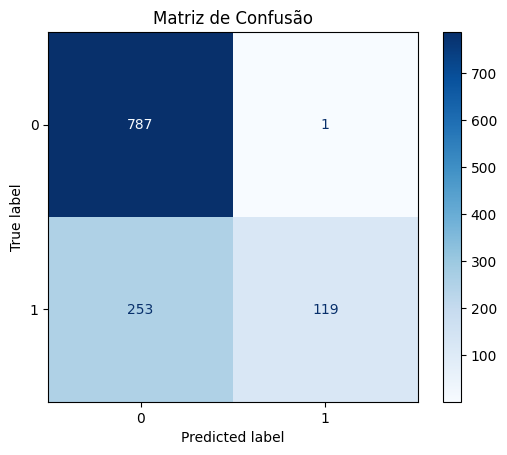

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model_lr = LogisticRegression()
model_lr.fit(X_train,y_train)

y_pred = model_lr.predict(X_test)

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # ou ['spam', 'ham']
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.97      0.89       788
           1       0.90      0.58      0.70       372

    accuracy                           0.84      1160
   macro avg       0.86      0.77      0.80      1160
weighted avg       0.85      0.84      0.83      1160



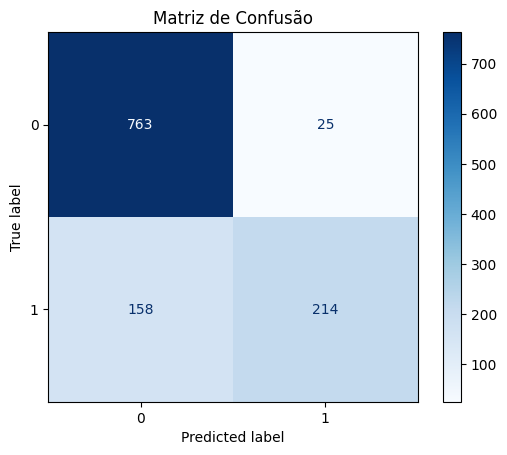

In [58]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train,y_train)

y_pred = model_rf.predict(X_test)

print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)  # ou ['spam', 'ham']
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()